In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick # For specifying the axes tick format 
import numpy as np
import seaborn as sns

plt.style.use('ggplot')
# pd.set_option('max_columns', 200)

# General EDA

In [6]:
def process_data(df):
    df = df.replace({
        "gender": {'M': 1, 'F': 0}})
    df['date'] = pd.to_datetime(df['date'])
    df['quantity'] = df['quantity'].astype(int)
    df['sales_amount'] = df['sales_amount'].astype(int)
    return df

In [7]:
df = pd.read_csv('merged_df.csv')
df = process_data(df)
df.head(5)

,id,date,customer_id,transaction_id,sku_category,sku,quantity,sales_amount,gender,age,country
0,1,2021-01-02,2547,1,X52,0EM7L,1,3,1,43,Greece
1,639,2021-01-04,2547,332,Q4N,MM3E0,1,12,1,43,Greece
2,7800,2021-01-25,2547,3743,X52,885U7,1,4,1,43,Greece
3,7801,2021-01-25,2547,3743,29A,A59HR,3,6,1,43,Greece
4,17633,2021-02-22,2547,8477,L9F,7W8WS,1,11,1,43,Greece


In [ ]:
df = df.drop(columns='id', axis=1)

In [11]:
df.head(5)

,date,customer_id,transaction_id,sku_category,sku,quantity,sales_amount,gender,age,country
0,2021-01-02,2547,1,X52,0EM7L,1,3,1,43,Greece
1,2021-01-04,2547,332,Q4N,MM3E0,1,12,1,43,Greece
2,2021-01-25,2547,3743,X52,885U7,1,4,1,43,Greece
3,2021-01-25,2547,3743,29A,A59HR,3,6,1,43,Greece
4,2021-02-22,2547,8477,L9F,7W8WS,1,11,1,43,Greece


questions i need to answer

sales analysis
what are the biggest countries in sales amount?
what are the trends in sales over time?

product analysis
what are the most sold sku and sku category per country?
what are the average value per sku and sku category, as well as the most and least valuable?
are there any skus or categories that are underperforming?

churn analysis
which products are frequently purchased by customer who later churn?

inventory and supply chain management
are there correlations between certain skus being purchased together?

time series analysis
how do sales fluctuate by day of the week or time of the month?
are there any seasonal patterns in sku category sales?


# Customer Segmentation

## RFM

Recency (R): How recently a customer has made a purchase. We can calculate this by finding the number of days since a customer's last purchase.

Frequency (F): How often a customer makes a purchase. We can calculate this by counting the number of transactions each customer has made.

Monetary (M): How much money a customer has spent. We can calculate this by summing up the sales amount for each customer.


In [12]:
# Determine the most recent date in the dataset for recency calculation
most_recent_date = df['date'].max() + pd.Timedelta(days=1)

# Calculate RFM metrics
rfm = df.groupby('customer_id').agg({
    'date': lambda x: (most_recent_date - x.max()).days,  # Recency (days since last purchase)
    'transaction_id': 'nunique',  # Frequency (total number of transactions)
    'sales_amount': 'sum'  # Monetary (total amount of money spent)
}).rename(columns={'date': 'recency', 'transaction_id': 'frequency', 'sales_amount': 'monetary'})

In [14]:
rfm.reset_index()

,customer_id,recency,frequency,monetary
0,1,344,1,15
1,2,196,2,22
2,3,364,1,10
3,4,53,2,31
4,5,180,5,78
...,...,...,...,...
22620,22621,22,1,9
22621,22622,16,1,6
22622,22623,11,1,127
22623,22624,30,1,18


In [15]:
# Calculate quartiles for RFM metrics
quartiles = rfm.quantile(q=[0.25, 0.5, 0.75])
quartiles = quartiles.to_dict()

In [16]:
# Functions to assign scores to Recency, Frequency, and Monetary
def r_score(x, p, d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

def fm_score(x, p, d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

# Assigning scores
rfm['r_score'] = rfm['recency'].apply(r_score, args=('recency', quartiles))
rfm['f_score'] = rfm['frequency'].apply(fm_score, args=('frequency', quartiles))
rfm['m_score'] = rfm['monetary'].apply(fm_score, args=('monetary', quartiles))

# Combining scores to create RFM Segment
rfm['rfm_segment'] = rfm['r_score'].map(str) + rfm['f_score'].map(str) + rfm['m_score'].map(str)

In [18]:
rfm.reset_index()

,customer_id,recency,frequency,monetary,r_score,f_score,m_score,rfm_segment
0,1,344,1,15,1,1,2,112
1,2,196,2,22,2,3,2,232
2,3,364,1,10,1,1,2,112
3,4,53,2,31,3,3,3,333
4,5,180,5,78,2,4,4,244
...,...,...,...,...,...,...,...,...
22620,22621,22,1,9,4,1,1,411
22621,22622,16,1,6,4,1,1,411
22622,22623,11,1,127,4,1,4,414
22623,22624,30,1,18,4,1,2,412


In [19]:
# Analyzing the size of each segment
segment_size = rfm['rfm_segment'].value_counts().reset_index()
segment_size.columns = ['rfm_segment', 'size']

# Calculating average values for RFM metrics in each segment
segment_analysis = rfm.groupby('rfm_segment').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'count']
}).reset_index()

segment_analysis.columns = ['rfm_segment', 'average_recency', 'average_frequency', 'average_monetary', 'count']

In [20]:
segment_analysis.sort_values(by='count', ascending=False).head(5)

,rfm_segment,average_recency,average_frequency,average_monetary,count
47,444,18.568084,10.899188,305.318204,2093
0,111,319.114504,1.000000,5.331767,1703
12,211,219.944272,1.000000,5.256347,1615
24,311,96.077470,1.000000,5.375494,1265
1,112,318.795473,1.000000,14.447858,1237


## Time series analaysis

In [22]:
df

,date,customer_id,transaction_id,sku_category,sku,quantity,sales_amount,gender,age,country
0,2021-01-02,2547,1,X52,0EM7L,1,3,1,43,Greece
1,2021-01-04,2547,332,Q4N,MM3E0,1,12,1,43,Greece
2,2021-01-25,2547,3743,X52,885U7,1,4,1,43,Greece
3,2021-01-25,2547,3743,29A,A59HR,3,6,1,43,Greece
4,2021-02-22,2547,8477,L9F,7W8WS,1,11,1,43,Greece
...,...,...,...,...,...,...,...,...,...,...
131701,2021-07-04,5751,32874,LSD,NSGRM,1,11,0,34,Germany
131702,2021-07-04,5751,32874,0H2,9Q5PZ,1,7,0,34,Germany
131703,2021-07-04,5751,32874,D6J,52BYA,1,40,0,34,Germany
131704,2021-07-04,10765,32881,Z4O,6IISH,1,1,0,43,Greece


## K-Means

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# ON SEGMENT

# Normalize the data
scaler = StandardScaler()
segment_normalized = scaler.fit_transform(segment_analysis[['rfm_segment', 'average_recency', 'average_frequency',
       'average_monetary']])

# Elbow Method to find the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(segment_normalized)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow Method graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [68]:
optimal_number_of_clusters = 3


# Fit K-means to the RFM data
kmeans = KMeans(n_clusters=optimal_number_of_clusters, init='k-means++', random_state=42)
segment_size['cluster'] = kmeans.fit_predict(segment_normalized)

/home/joao/miniconda3/envs/capstone/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
segment_size

In [67]:
segment_normalized['cluster']

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

/home/joao/miniconda3/envs/capstone/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/joao/miniconda3/envs/capstone/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/joao/miniconda3/envs/capstone/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/joao/miniconda3/envs/capstone/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarni

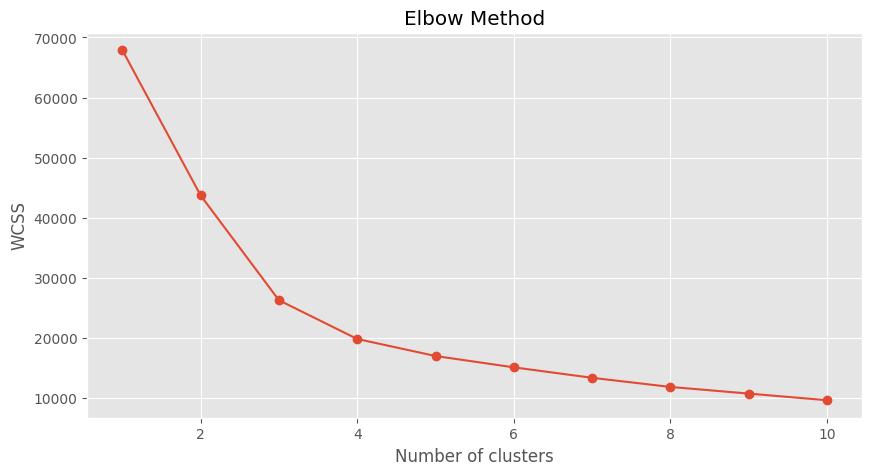

In [40]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assuming rfm is your RFM DataFrame

# Normalize the data
scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(rfm[['recency', 'frequency', 'monetary']])

# Elbow Method to find the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(rfm_normalized)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow Method graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [42]:
optimal_number_of_clusters = 3


# Fit K-means to the RFM data
kmeans = KMeans(n_clusters=optimal_number_of_clusters, init='k-means++', random_state=42)
rfm['cluster'] = kmeans.fit_predict(rfm_normalized)

/home/joao/miniconda3/envs/capstone/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [43]:
rfm

,customer_id,recency,frequency,monetary,r_score,f_score,m_score,rfm_segment,cluster
0,1,344,1,15,1,1,2,112,2
1,2,196,2,22,2,3,2,232,2
2,3,364,1,10,1,1,2,112,2
3,4,53,2,31,3,3,3,333,0
4,5,180,5,78,2,4,4,244,0
...,...,...,...,...,...,...,...,...,...
22620,22621,22,1,9,4,1,1,411,0
22621,22622,16,1,6,4,1,1,411,0
22622,22623,11,1,127,4,1,4,414,0
22623,22624,30,1,18,4,1,2,412,0


# Calculating Customer Lifetime Value (CLV)

In [ ]:
# repeat rate = customer with at least 2 transactions / total customers number

# count the number of transactions for each customer_id
transaction_counts = merged_df.groupby('customer_id')['transaction_id'].nunique()

# determine which customers have at least 2 transactions
customer_two_trans = transaction_counts[transaction_counts >= 2].count()

# total number of customers
total_customers = merged_df['customer_id'].nunique()

# repeat rate
repeat_rate  = customer_two_trans / total_customers

print("Repeat rate:", repeat_rate)

In [ ]:
# churn rate = 1 - repat_rate

churn_rate = 1 - repeat_rate
churn_rate

In [ ]:
# average customer lifespan (ACL) = 1 / churn rate

acl = 1 / churn_rate
acl

In [ ]:
# average purchase frequency (APF) = total number of purchases / total customers number

total_purchases = merged_df['transaction_id'].nunique()

apf = total_purchases / total_customers
apf

In [ ]:
# Avg. Purchase Value (APV) = Total Revenue / Total Number of Purchases

total_revenue = merged_df['sales_amount'].sum()

apv = total_revenue / total_purchases
apv

In [ ]:
# customer lifetime value (CLV) = Avg. Purchase Value * Avg. Purchase Frequency * Avg. Customer Lifespan

clv = apv * apf * acl
clv

In [ ]:
# calculate total revenue and number of purchases per customer

customer_revenue = merged_df.groupby('customer_id')['sales_amount'].sum()

# calculating the avg purchase value (apv) per customer_id

customer_apv = customer_revenue / transaction_counts
customer_apv.describe()

In [ ]:
# average customer lifespan
# TO-DO check other approaches to customer lifespan
customer_first_purchase = merged_df.groupby('customer_id')['date'].min()
customer_last_purchase = merged_df.groupby('customer_id')['date'].max()
customer_lifespan = (customer_last_purchase - customer_first_purchase).dt.days
average_customer_lifespan = customer_lifespan.mean()
average_customer_lifespan

In [ ]:
customer_lifespan.plot(kind='hist', bins=5)
plt.show()

In [ ]:
lifespan = customer_lifespan.to_frame(name='lifespan')
lifespan = lifespan.reset_index()
lifespan

In [ ]:
sns.boxplot(data=lifespan['lifespan'])

In [ ]:
# lifepsan.to_csv('rfm2.csv', index=True)

In [ ]:
# clv for each customer

customer_clv = customer_apv * apf * average_customer_lifespan
customer_clv.head()

In [ ]:
customer_clv_df = customer_clv.to_frame(name='clv')
customer_clv_df

In [ ]:
customer_clv_df.reset_index()

In [ ]:
# rfm.to_csv('rfm2.csv', index=True)

In [ ]:
segment_analysis.head(20)

In [ ]:
# .to_csv('rfm1.csv', index=False)

In [ ]:
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]

In [ ]:
df['sales_amount'].quantile(quantiles).to_frame()

,sales_amount
0.05,1.89
0.25,4.23
0.50,6.92
0.75,12.33
0.95,36.41


- 0.05 (5th percentile): 95% of transactions have a sales amount greater than 1.89. This suggests that the lower end of transaction values is around this amount.
- 0.25 (25th percentile): 75% of transactions have a sales amount greater than 4.23. This is the first quartile,-  indicating the lower-middle range of sales amounts.
- 0.50 (50th percentile or median): Half of the transactions have a sales amount greater than 6.92. This is your median transaction value.
- 0.75 (75th percentile): 25% of transactions have a sales amount greater than 12.33. This is the upper-middle range of sales amounts.
- 0.95 (95th percentile): Only 5% of transactions have a sales amount greater than 36.41. This indicates a relatively high sales amount per transaction.

In [ ]:
sku_agg['sales_amount'].quantile(quantiles).to_frame()

,sales_amount
0.05,5.2100
0.25,22.5825
0.50,77.0850
0.75,252.6450
0.95,1255.2365


- 0.05 (5th percentile): 95% of SKUs have a total sales amount greater than 5.21. This indicates that the least performing 5% of SKUs contribute relatively low to total sales.
- 0.25 (25th percentile): 75% of SKUs have a total sales amount greater than 22.58. This suggests that the lower 25% of SKUs contribute modestly to overall sales.
- 0.50 (50th percentile or median): Half of the SKUs have a total sales amount greater than 77.08. This median value is significantly higher than the median of individual transactions, indicating that certain SKUs contribute more substantially to sales.
- 0.75 (75th percentile): The top 25% of SKUs have a total sales amount greater than 252.64, indicating that these SKUs are likely the main drivers of sales.
- 0.95 (95th percentile): The top 5% of SKUs generate more than 1255.24 in sales, highlighting the significant contribution of top-performing SKUs.

In [ ]:
sku_cat_agg['sales_amount'].quantile(quantiles).to_frame()

,sales_amount
0.05,60.783
0.25,727.005
0.50,2499.560
0.75,9527.840
0.95,34740.679


- 0.05 (5th percentile): 95% of SKU categories have a total sales amount greater than 60.783. This suggests that the lowest-performing 5% of SKU categories contribute relatively small amounts to the total sales.
- 0.25 (25th percentile): 75% of SKU categories have a total sales amount greater than 727.005. This is the first quartile, indicating the lower-middle range of total sales amounts for SKU categories.
- 0.50 (50th percentile or median): Half of the SKU categories have a total sales amount greater than 2499.560. This is your median sales value per category, showing a significant jump from the 25th percentile, indicating that the higher half of the categories contribute more substantially to sales.
- 0.75 (75th percentile): The top 25% of SKU categories have a total sales amount greater than 9527.840. These categories are likely the major contributors to your sales, indicating higher popularity or higher-priced items in these categories.
- 0.95 (95th percentile): The top 5% of SKU categories generate more than 34740.679 in sales, highlighting a significant contribution from these top-performing categories.

## Sales Analysis

#### What are the biggest countries in sales amount?

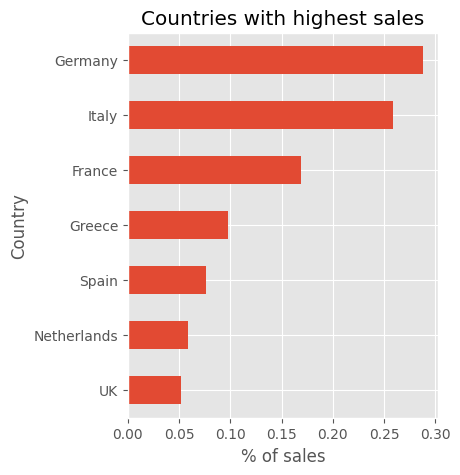

In [3]:
ax = df['country'].value_counts(ascending=True, normalize=True) \
        .plot(kind='barh',
              figsize=(4, 5))

ax.set_ylabel('Country')
ax.set_xlabel('% of sales')
ax.set_title('Countries with highest sales')

plt.show()

## Demographics

### What is the distribution of sales between genders?

Text(0, 0.5, 'Gender')

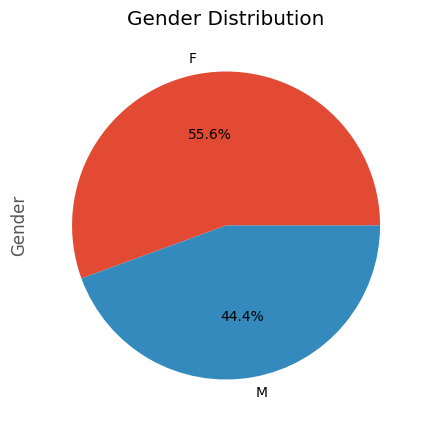

In [4]:
ax = df.groupby('gender')['sales_amount'].sum() \
        .plot(kind='pie',
              autopct='%.1f%%',
              figsize=(5,5))

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_title('Gender Distribution')
ax.set_ylabel('Gender')

<Axes: >

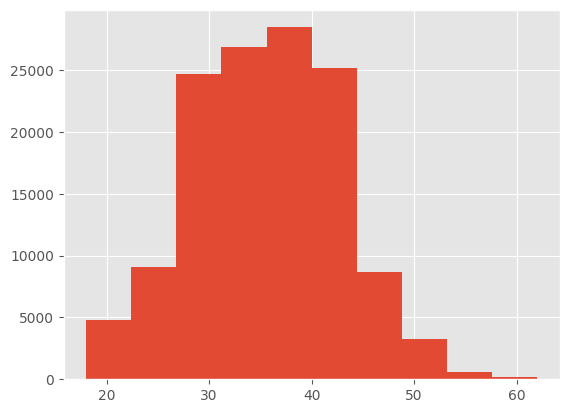

In [5]:
df['age'].hist(bins=10)

In [6]:
ax = df.groupby('country').agg({'quantity': 'sum',
                                'sales_amount': 'sum'}).reset_index()
                                        
ax.sort_values(by='sales_amount', ascending=False).head(10)

,country,quantity,sales_amount
1,Germany,56274.227,459938.66
3,Italy,50714.712,410646.81
0,France,32621.360,259667.37
2,Greece,19370.000,151657.60
5,Spain,14783.990,119828.15
4,Netherlands,11407.590,92740.61
6,UK,10453.450,83559.42


## Product Analysis

### What are the most sold sku and sku category per country?

product analysis
what are the most sold sku and sku category per country?
what are the average value per sku and sku category, as well as the most and least valuable?
are there any skus or categories that are underperforming?

In [30]:
sku_agg = df.groupby('sku').agg({'quantity': 'sum',
                                'sales_amount': 'sum'}).reset_index()
                                        
sku_agg.sort_values(by='sales_amount', ascending=False).head(5)

,sku,quantity,sales_amount
606,3YDVF,926.0,29419.35
3178,LJ26I,632.0,13571.45
2752,IRQZ4,321.0,11681.63
2071,DWJC4,823.0,10592.09
621,44RUE,218.0,8942.63


In [31]:
sku_cat_agg = df.groupby('sku_category').agg({'quantity': 'sum',
                                        'sales_amount': 'sum'}).reset_index()
sku_cat_agg.sort_values(by='sales_amount', ascending=False).head(5)

,sku_category,quantity,sales_amount
30,6BZ,2833.660,114061.33
155,SJS,2883.330,85142.31
106,LPF,8210.043,84921.91
131,OXH,3884.670,54470.16
119,N8U,12148.000,49119.55


In [32]:
# applying tiers from 0 (lowest) to 9 (highest) to sku_category

sku_category_sales = df.groupby('sku_category')['sales_amount'].sum().reset_index()
sku_category_sales['sales_tier'] = pd.qcut(sku_category_sales['sales_amount'], q=10, labels=False)
sku_category_sales.head(5)

,sku_category,sales_amount,sales_tier
0,01F,38029.87,9
1,06Z,8619.17,7
2,0H2,29875.14,9
3,0KX,2044.45,4
4,0WT,4052.49,6


In [33]:
customer_sales = df.groupby('customer_id')['sales_amount'].sum().reset_index()
customer_sales['customer_tier'] = pd.qcut(customer_sales['sales_amount'], q=10, labels=False)
customer_sales.head(5)

,customer_id,sales_amount,customer_tier
0,1,16.29,3
1,2,22.77,4
2,3,10.92,2
3,4,33.29,5
4,5,78.82,7
